# Basics
This notebook will show you the basics to get started using Lightnet.  
Before reading these tutorials, it is strongly recommended to have an understanding of how PyTorch works.
You can find some tutorials on their [website](https://pytorch.org/tutorials/).

The first part of this tutorial will show you how to load the lightnet provided networks and loss functions, as well as where to find all the layers so you can build your own networks.  
After that, we will take a look at the included data processing functionality, so you can easily setup a pipeline to train your networks.  
Finally, we will look at the post-processing that is included in Lightnet, which allows you to save your detection results once you finished training a model.


<div class="alert alert-warning">

**Warning:**

The images and annotations below are from the Pascal VOC challenge. To be able to run this notebook, download any image and place it in the same directory as the notebook as _example.jpg_ and its matching annotations as _example.xml_ (pascalvoc format).  
__We do not own any of the images shown here!__

</div>

In [14]:
# Basic imports
import lightnet as ln
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import brambox as bb

# Settings
ln.logger.setConsoleLevel('ERROR')             # Only show error log messages
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

## Networks
This section will take a closer look at the premade models that are included in lightnet, as well as how to create your own models.

You can find all premade networks under [lightnet.models](../api/models.rst#networks).  
They are nothing more than `torch.nn.Module` classes, which implement a forward function.

In [2]:
model = ln.models.TinyYoloV2(20)

# Short representation
print(model)

print()

# Long representation
print(repr(model))

lightnet.models._network_tiny_yolo_v2.TinyYoloV2(num_classes=20, input_channels=3, anchors=[(1.08, 1.19), (3.42, 4.41), (6.63, 11.38), (9.42, 5.11), (16.62, 10.52)])

TinyYoloV2(
  (layers): Sequential(
    (1_convbatch): Conv2dBatchReLU(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
    (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3_convbatch): Conv2dBatchReLU(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
    (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5_convbatch): Conv2dBatchReLU(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
    (6_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7_convbatch): Conv2dBatchReLU(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slo

### Weights

These lightnet models have some extra functionality regarding saving and loading of weights.  
First and foremost, the networks that come straight from the [darknet](https://github.com/pjreddie/darknet/tree/master/cfg) framework can load and save weights as darknet `.weights` files.

Another addition is that you can remap weights when saving them.
This allows to easily save eg. [Darknet19](../api/generated/lightnet.models.Darknet19.rst) weights as starting weights for the [YoloV2](../api/generated/lightnet.models.YoloV2.rst) network.  
Remapping works by giving a list of `(<source_layer>, <target_layer>)` regex strings to the [save](../api/generated/lightnet.network.module.Lightnet.rst#lightnet.network.module.Lightnet.save) function.
These regex strings should match with keys from the `state_dict()` from the 2 different models.  
As this can be quite complex to write yourself, most models included in lightnet provide remapping lists as class attributes on the target models.

In [3]:
# Loading darknet weights (download: http://pjreddie.com/media/files/darknet19_448.weights)
model = ln.models.Darknet19(1000)
model.load('darknet19_448.weights')

# Save as PyTorch weight file (Not strictly necessary, but it is faster than darknet weight files)
model.save('darknet19_448.pt')

# Converting Darknet19 weights to Yolo (This is the same as the darknet19_448.conv.23.weights from darknet)
model.save('yolo-pretrained_darknet.pt', remap=ln.models.YoloV2.remap_darknet19)

# Load yolo weights (Requires `strict=False`, because not all layers have weights in this file)
detection_model = ln.models.Yolo(20)
detection_model.load('yolo-pretrained_darknet.pt', strict=False)

Alternatively, you can perform the remapping whilst loading pytorch weightfiles as well.

In [4]:
model = ln.models.YoloV2(20)
model.load('darknet19_448.pt', remap=model.remap_darknet19, strict=False)

### Training

While classification networks can be trained with a simple [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss), training the Yolo detection networks requires a more complicated [RegionLoss](../api/generated/lightnet.network.loss.RegionLoss.rst) function, which we reimplemented in lightnet.

Here is a basic example of creating this loss function, which behaves exactly like any pytorch loss function.

In [5]:
# Create detection model
model = ln.models.YoloV2(1)

# Create accompanying loss (minimal required arguments for it to work with our defined Yolo network)
loss = ln.network.loss.RegionLoss(
    num_classes=model.num_classes,
    anchors=model.anchors,
    stride=model.stride
)
print(loss)

# Use loss
input_tensor = torch.rand(1, 3, 416, 416)   # batch, channel, height, width
target_tensor = torch.rand(1, 2, 5)         # batch, num_anno, 5 (see RegionLoss docs)

output_tensor = model(input_tensor)
loss_value = loss(output_tensor, target_tensor)
print(f'Loss: {loss_value.item()}')

RegionLoss(
  classes=1, stride=32, threshold=0.6, seen=0
  coord_scale=1.0, object_scale=5.0, noobject_scale=1.0, class_scale=1.0
  anchors=[1.3221, 1.7314] [3.1927, 4.0094] [5.0559, 8.0989] [9.4711, 4.8405] [11.236, 10.007] 
  (mse): MSELoss()
  (cel): CrossEntropyLoss()
)
Loss: 119.7525405883789


You can now create your custom pytorch dataloaders and start training lightnet models,
but if you'd rather create your own networks, you can do that as well and use all available layers from [lightnet.network.layer](../api/network.rst#layer).

### Custom Networks
All the building blocks that are used to create networks in lightnet are separate modules, which allows you to easily scaffold out your own networks as well.


<div class="alert alert-info">

**Note:**

You can take a look at the implementations of the [included lightnet networks](https://gitlab.com/eavise/lightnet/tree/master/lightnet/models) for extra examples on how to use the layers of this library to build your own networks!

</div>

In [6]:
custom_model = torch.nn.Sequential(
    ln.network.layer.Conv2dBatchReLU(3, 32, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(32, 64, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(64, 128, 3, 1, 1),
    ln.network.layer.InvertedBottleneck(128, 128, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(128, 64, 3, 1, 1),
    torch.nn.Conv2d(128, 1, 1, 1, 0)
)

print(custom_model)

Sequential(
  (0): Conv2dBatchReLU(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), ReLU(inplace=True))
  (1): Conv2dDepthWise(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), ReLU(inplace=True))
  (2): Conv2dDepthWise(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), ReLU(inplace=True))
  (3): InvertedBottleneck(128, 128, kernel_size=(3, 3), stride=(1, 1), expansion=1, ReLU(inplace=True), residual_connection)
  (4): Conv2dDepthWise(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), ReLU(inplace=True))
  (5): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)


## Pre-processing pipeline
This section of the tutorial discusses the different pre-processing functions that are available in lightnet and how they work.

There are 2 different kinds of pre-processing classes in lightnet:

- [BaseTransform](../api/generated/lightnet.data.transform.util.BaseTransform.rst): These classes perform some kind of modification to a single object, which is usually an image.
- [BaseMultiTransform](../api/generated/lightnet.data.transform.util.BaseMultiTransform.rst): These classes perform a modification to multiple objects, like an image and its associated annotations.
  
All transformation operators work with either [OpenCV](https://opencv.org) or [PIL/Pillow](https://pillow.readthedocs.io) images and can also work on PyTorch Tensors.  
The multi-transform operators that work on annotations, work with brambox annotation dataframes.
This means that if you want to use the pre-processing functionality provided by lightnet, you should install brambox.

Note that the brambox package is not included as a dependency of lightnet, as you might want to use lightnet for inference on constrained devices and thus not want to install brambox and all its dependencies.  
The only use of brambox for lightnet is during training (pre-processing and loss function) and if you want to perform statistics of your models (eg. PR). Both of these functionalities are not neccesary for inference.

```bash
pip install brambox
```

### Base Transforms
Any transformation defined in Lightnet that only transforms the image, is defined as a [ln.data.transform.util.BaseTransform](../api/generated/lightnet.data.transform.util.BaseTransform.rst).  
Using these transformation operators is as easy as instantiating it and calling it with an image.

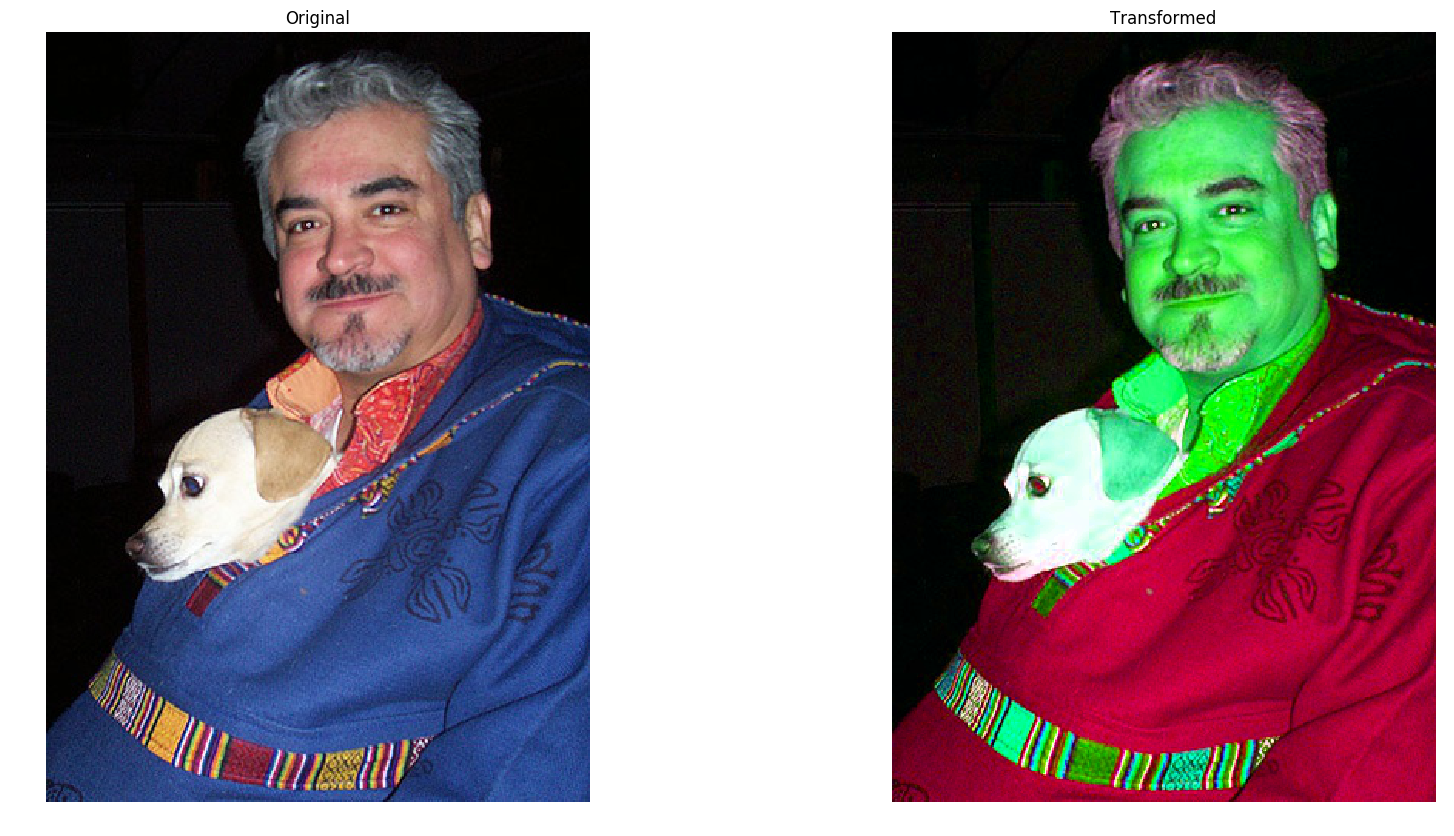

In [7]:
# Load image
img = Image.open('example.jpg')

# BaseTransform  -> Perform HSV shift
hsv = ln.data.transform.RandomHSV(
    hue=1,
    saturation=2,
    value=2
)

img_tf = hsv(img)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(img))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(img_tf))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

If you only need to use a certain transformation once, there is a static ``apply()`` method for convenience:

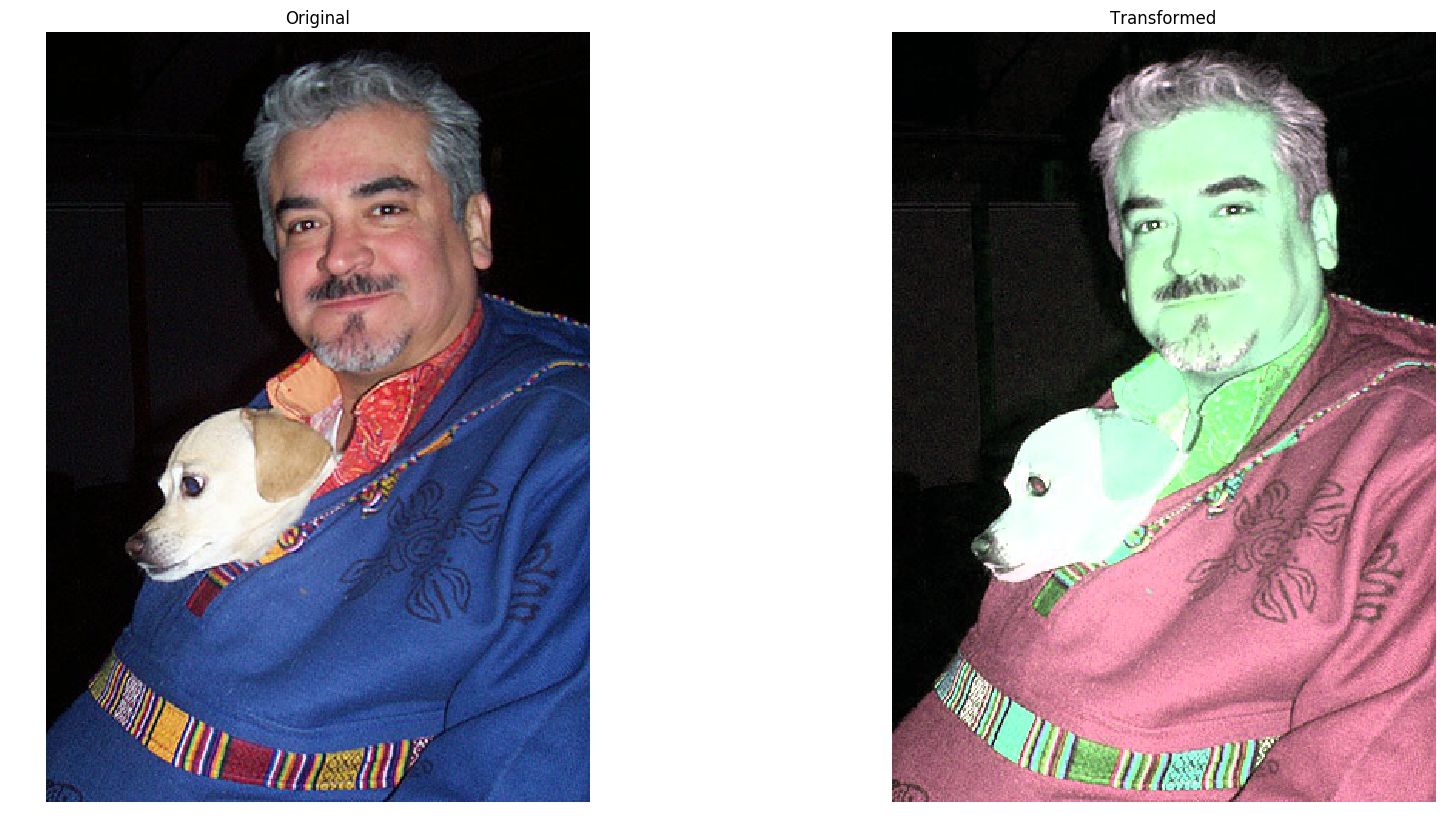

In [8]:
img = Image.open('example.jpg')
img_tf = ln.data.transform.RandomHSV.apply(img, hue=1, saturation=2, value=2)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(img))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(img_tf))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

### Base Multi Transforms

Any transformation that modifies both image and annotation data, is defined as a [ln.data.transforms.util.BaseMultiTransform](../api/generated/lightnet.data.transform.util.BaseMultiTransform.rst).  
To use these operators, you first call them with the image.
The operator will compute all the necessary values to perform the transformation, store them and apply them to the image.
Afterwards, when you call that same operator with an annotation dataframe, it will use the stored values to perform the same transformation to your annotations.

As you can see, it is important to apply the transformation in the right order, because as soon as you apply the operator to a new image, it will overwrite the transformation parameters with new ones.

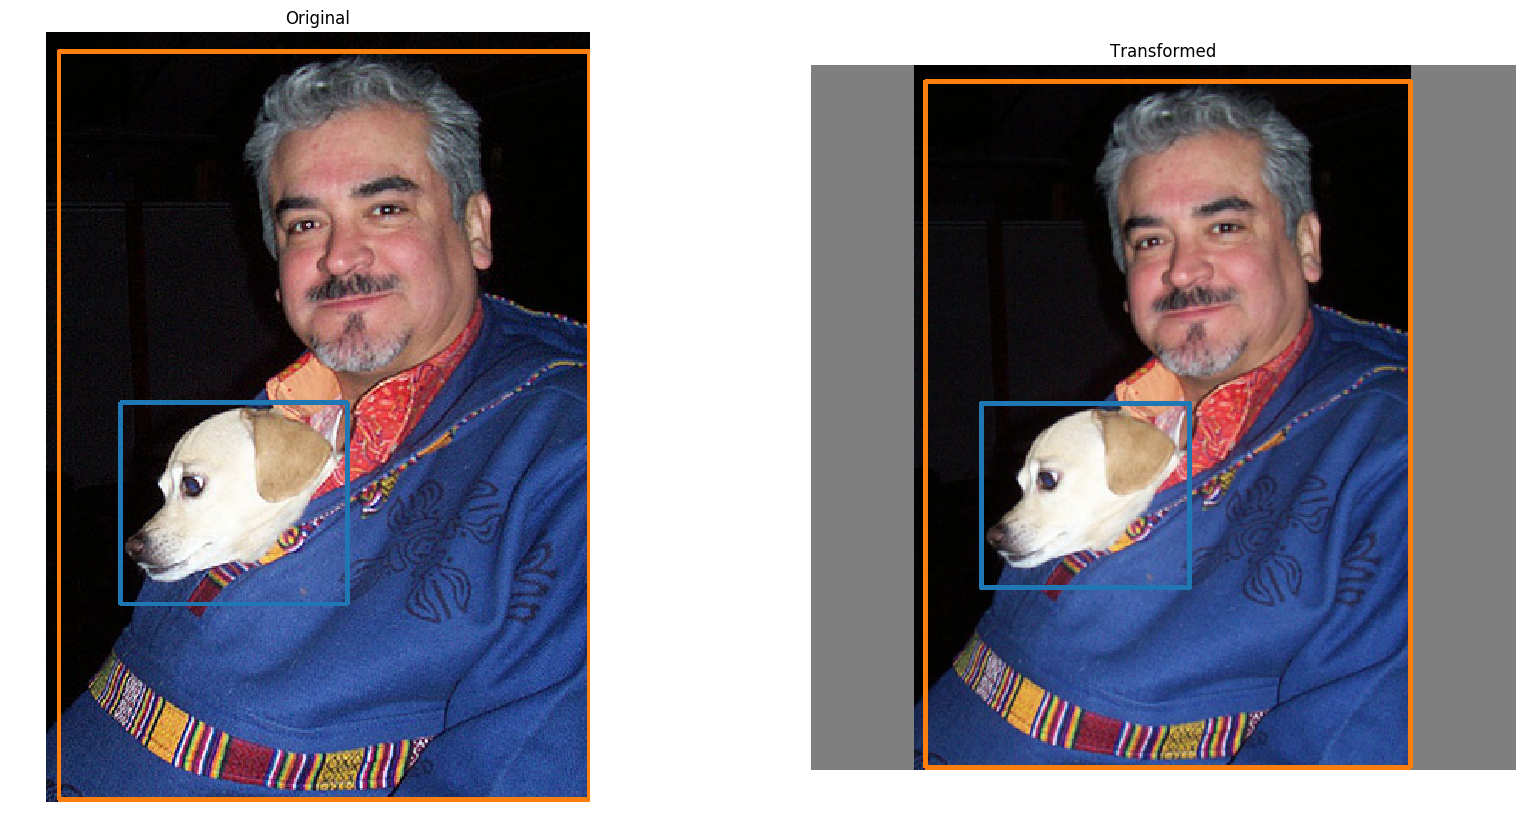

In [17]:
# Load image and annotations
img  = Image.open('example.jpg')
anno = bb.io.load('anno_pascalvoc', 'example.xml')

# BaseMultiTranform  -> Letterbox img/anno to 416x416
lb = ln.data.transform.Letterbox(
    dimension=(416, 416)
)

img_tf  = lb(img)
anno_tf = lb(anno)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(bb.util.draw_boxes(img, anno)))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(bb.util.draw_boxes(img_tf, anno_tf)))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

Yet again, there is the ``apply()`` convenience method you can use if you only need to apply a transformation once.

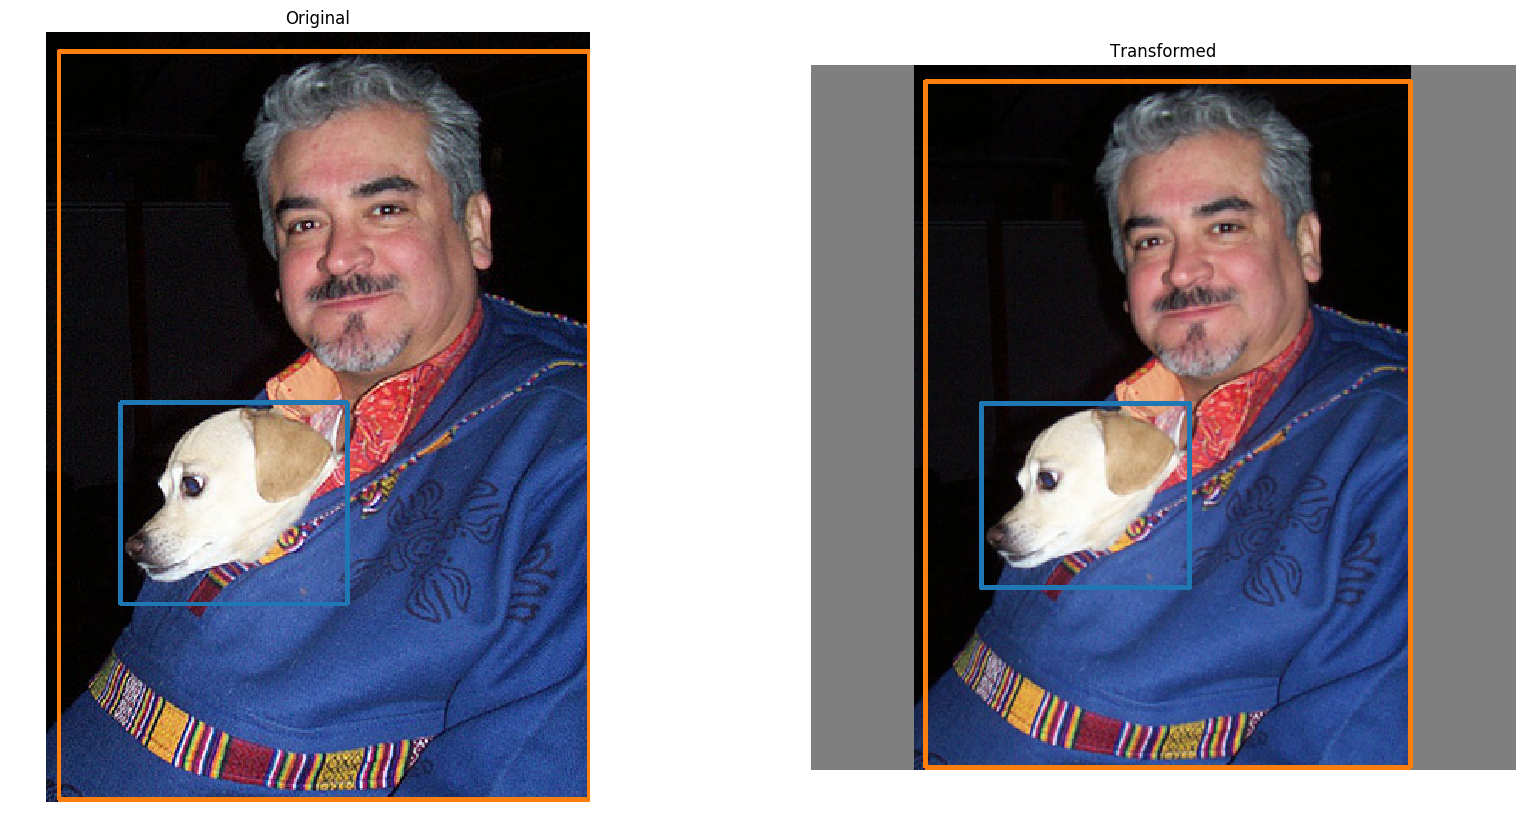

In [16]:
img  = Image.open('example.jpg')
anno = bb.io.load('anno_pascalvoc', 'example.xml')
img_tf, anno_tf = ln.data.transform.Letterbox.apply(img, anno, dimension=(416, 416))

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(bb.util.draw_boxes(img, anno)))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(bb.util.draw_boxes(img_tf, anno_tf)))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

### Transformation Pipelines

All these transformation operators are meant to work seamlessly in a pytorch dataset/dataloader environment and can be used with the [torchvision.transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose), but lightnet also provides its own [ln.data.transforms.Compose](../api/generated/lightnet.data.transform.Compose.rst) class, which adds more advanced features to the mix.

The Compose class in PyTorch is designed to create single pipelines, where we only modify the image data.
For the case of object detection however, we need to modify both images and annotations.
We also need to know which annotations are linked with which images, so that we can perform the same random data augmentation and both pieces of data stay nicely linked together.

The way we can achieve this, is by creating 2 different transformation pipelines, one for images and one for annotations, but we use the same transform operator instances:

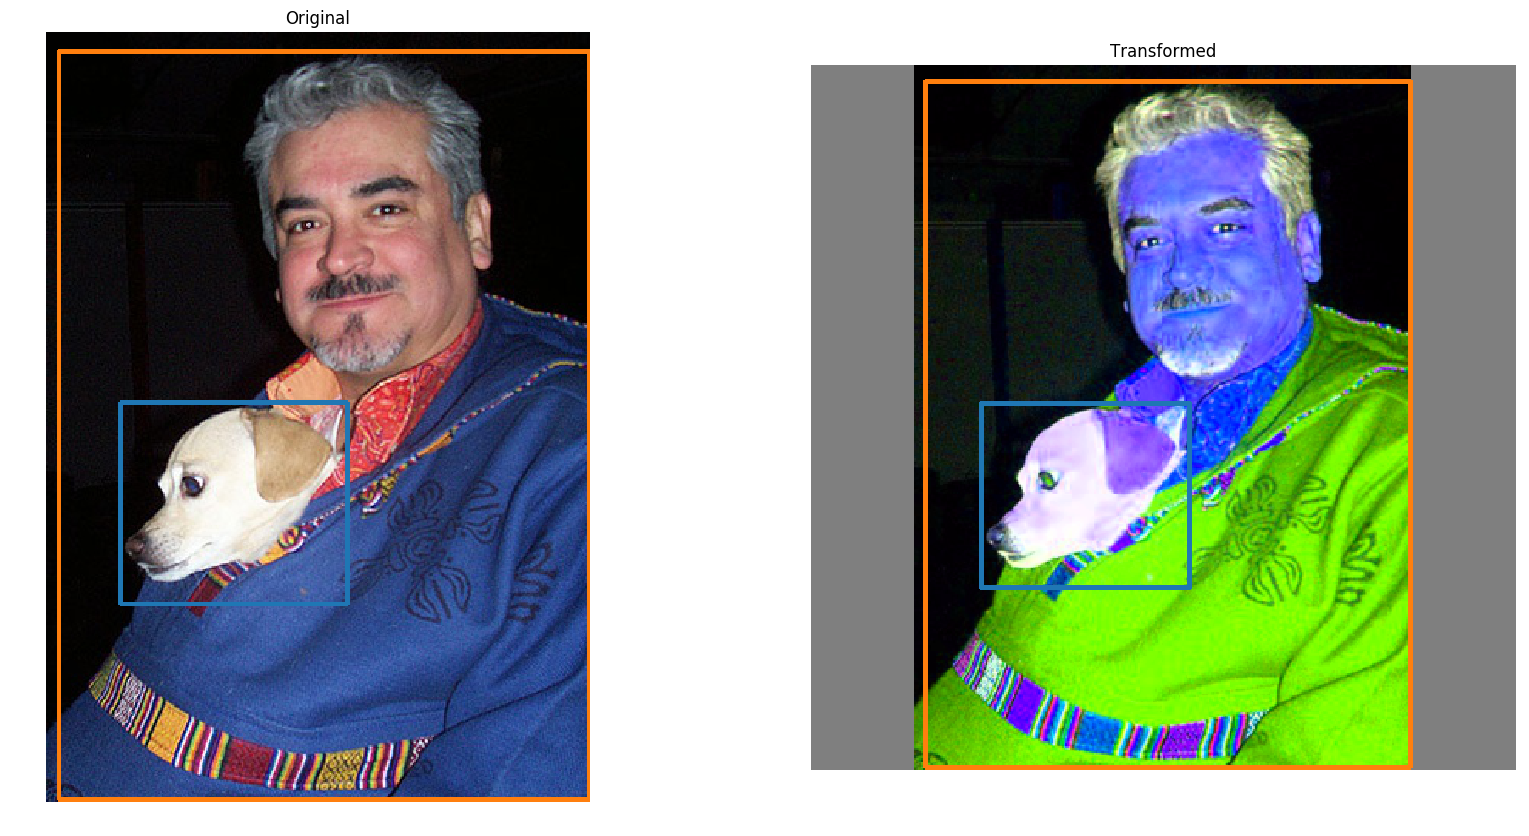

In [19]:
# Create single transform instances
hsv = ln.data.transform.RandomHSV(hue=1, saturation=2, value=2)
lb = ln.data.transform.Letterbox(dimension=(416, 416))

# Create 2 separate transformation pipelines
# Note that the annotation pipeline should not get the HSV transform, as it only modifies images
img_pipeline = torchvision.transforms.Compose([hsv, lb])
anno_pipeline = torchvision.transforms.Compose([lb])

# Use pipelines on data
img  = Image.open('example.jpg')
anno = bb.io.load('anno_pascalvoc', 'example.xml')

img_tf  = img_pipeline(img)
anno_tf = anno_pipeline(anno)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(bb.util.draw_boxes(img, anno)))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(bb.util.draw_boxes(img_tf, anno_tf)))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

While the example above works perfectly fine, it is quite tiresome to need to create named instances of your transform operators and use them in 2 different transformation pipelines, whilst making sure to only use the correct operators for each pipeline.

The example above works with lightnet's own [Compose](../api/generated/lightnet.data.transform.Compose.rst) class as well, but by using this class, you can simplify this pipeline quite a bit.  
This new class allows you to run your pipeline on both your image and annotation data in one call.
It does this by looking at the transformation operators in the pipeline.
If the operator is a [BaseMultiTransform](../api/generated/lightnet.data.transform.util.BaseMultiTransform.rst), it runs the transformation on both image and annotations, otherwise it only runs the transformation on the image data.

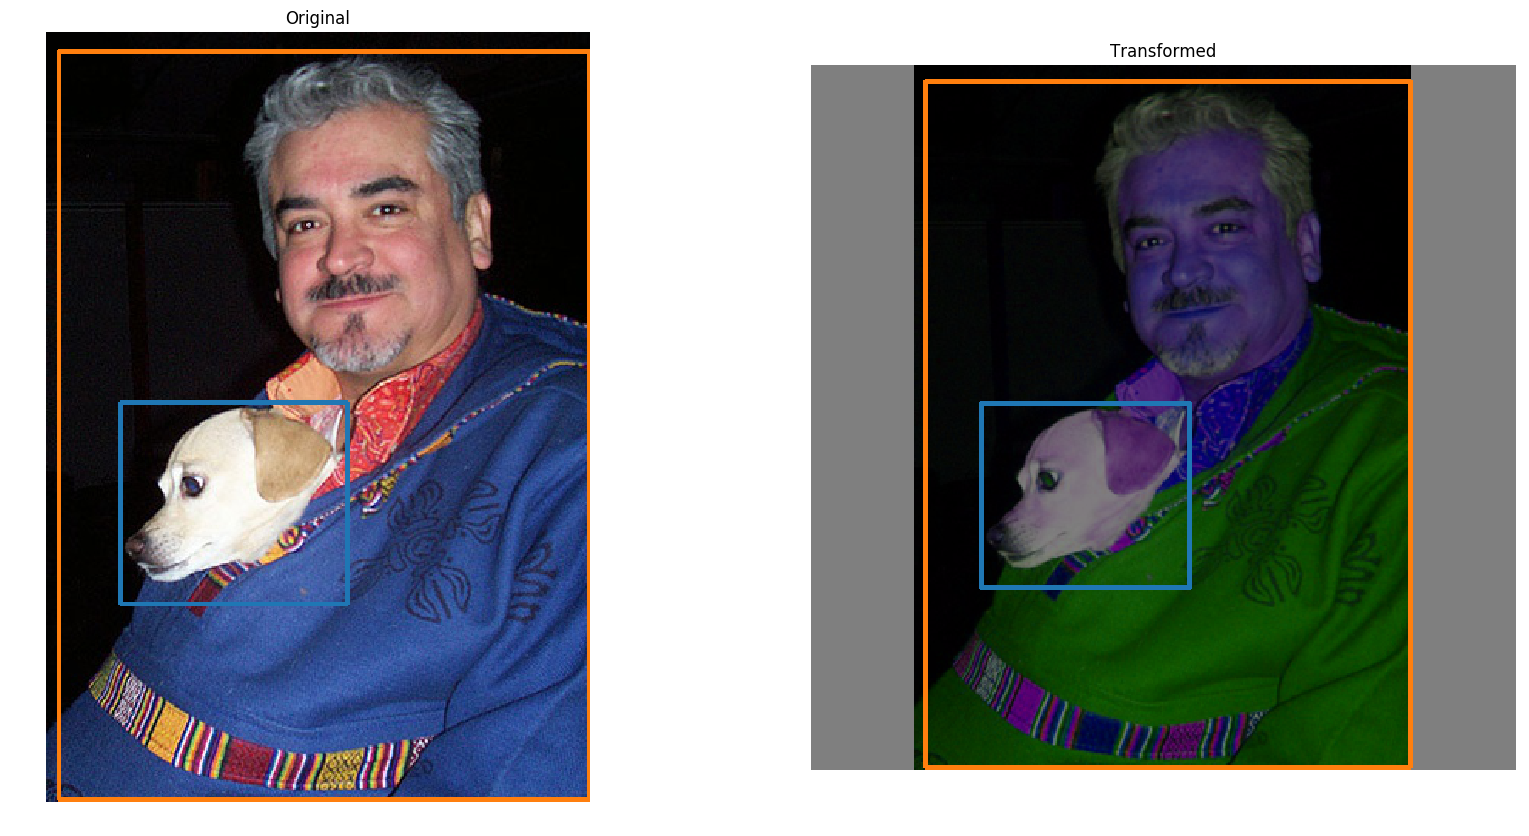

In [22]:
# Create a single transformation pipeline
pipeline = ln.data.transform.Compose([
    ln.data.transform.RandomHSV(hue=1, saturation=2, value=2),
    ln.data.transform.Letterbox(dimension=(416, 416)),
])

# Use pipeline on data
# Note that you need to pass the image and annotations as a tuple!
img  = Image.open('example.jpg')
anno = bb.io.load('anno_pascalvoc', 'example.xml')
img_tf, anno_tf = pipeline((img, anno))

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(bb.util.draw_boxes(img, anno)))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(bb.util.draw_boxes(img_tf, anno_tf)))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

<div class="alert alert-info">

**Note:**

Our own custom [Compose](../api/generated/lightnet.data.transform.Compose.rst) class has a few other advantages as well, like being able to merge multiple pipelines together, appending a transformation or even inserting one in an arbitrary place.
Take a look at the API documentation for a few examples.

</div>

## Post-processing pipeline
In this final section, we will talk about the post-processing functionality included in lightnet, which allows to convert the output tensors of a detector to a brambox dataframe.

The post-processing operators are not that different from the pre-processing ones.
In fact, they are also implemented as subclasses from [BaseTransform](../api/generated/lightnet.data.transform.util.BaseTransform.rst), and thus behave in exactly the same way!
The only difference lies in their input and output formats, which are different depending on the operator.

The operators can be roughly organised in 4 categories:
- __GetBoxes__ : Transform network output tensor to a common tensor format containing bounding boxes.
- __Filtering__ : Filter down bounding boxes based on some criteria. These transforms can work on both the common tensor format or brambox dataframes.
- __Reverse Fit__ : Undo fit pre-processing transformations (letterboxing, padding, etc.). These transformations can only work on brambox dataframes.
- __Others__ : Miscelaneous transformations, read the API documentation of each transform for more information.

As an example we will show a commonly used post-processing pipeline, which is used to transform the output tensor from the [YoloV2](../api/generated/lightnet.models.YoloV2.rst) network to a brambox detection dataframe.

In [27]:
# Load model
class_label_map = ['person']
model = ln.models.YoloV2(num_classes=len(class_label_map))

# Create post-processing pipeline
post = ln.data.transform.Compose([
    # GetBoxes transformation generates bounding boxes from network output
    ln.data.transform.GetDarknetBoxes(
        conf_thresh=0.5,
        network_stride=model.stride,
        anchors=model.anchors
    ),
    
    # Filter transformation to filter the output boxes
    ln.data.transform.NonMaxSuppression(
        nms_thresh=0.5
    ),
    
    # Miscelaneous transformation that transforms the output boxes to a brambox dataframe
    ln.data.transform.TensorToBrambox(
        class_label_map=class_label_map,
    )
])

# Run model (on garbage random data)
input_tensor = torch.rand(2, 3, 416, 416)   # 2 random images of 416x416

with torch.no_grad():
    output_tensor = model(input_tensor)
    output_df = post(output_tensor)

# Show output (head and tail to show the detections from the 2 images)
display(output_df.head())
display(output_df.tail())

image class_label  id  x_top_left  y_top_left      width      height  \
0      0      person NaN   -7.479089  -30.566921  41.661041   88.772049   
1      0      person NaN   44.303978  -20.641768  60.365021   77.168938   
2      0      person NaN   93.174210  -39.481087  33.143951  113.172737   
3      0      person NaN  122.487579  -32.541626  32.054657   95.018776   
4      0      person NaN  149.201050   -9.637924  57.291534   48.381283   

   confidence  
0    0.512785  
1    0.509053  
2    0.607668  
3    0.542335  
4    0.515991

image class_label  id  x_top_left  y_top_left       width      height  \
448      1      person NaN -214.819489  248.519257  528.353149  248.312988   
449      1      person NaN   70.768250  281.478973  339.428619  173.905212   
450      1      person NaN  102.234924  196.141693  413.217957  336.090851   
451      1      person NaN  217.564072  259.255585  315.472107  211.691162   
452      1      person NaN  -21.309731  282.508972  265.622894  232.051147   

     confidence  
448    0.641753  
449    0.594227  
450    0.522133  
451    0.613164  
452    0.529596

<div class="alert alert-warning">

**Warning:**

The [TensorToBrambox](../api/generated/lightnet.data.transform.TensorToBrambox.rst) function creates a valid brambox dataframe, except that the image column is just a numerical column containing the batch_number of the image.
It is up to the user to connect these numbers to the right image name (and optionally create a categorical column).

</div>